wires: 2
wires: 3
wires: 4
wires: 5
wires: 6
wires: 7
wires: 2
5.17931766808033e-07
wires: 3
4.6548666432499886e-07
wires: 4
4.42300612727801e-07
wires: 5
4.132161848247051e-07
wires: 6
4.079658538103104e-07
wires: 7
4.3680969004829723e-07


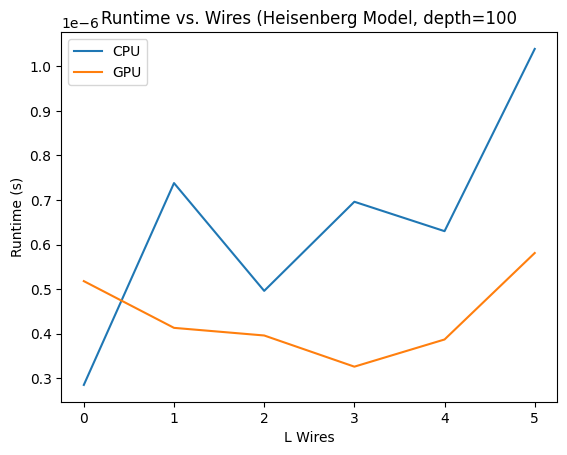

In [1]:
import json
from xxlimited import Xxo
import pennylane as qml
import pennylane.numpy as np
from timeit import default_timer as timer

#num_wires = 10 #increase this

#dev = qml.device("default.mixed", wires=num_wires) #lightning.qubit # lightning.gpu


import matplotlib.pyplot as plt
def draw_circuit_nice(function:qml.qnode, *args):
    "draw quantum function from pennylane in a nice visual format"
    qml.drawer.use_style("black_white")
    fig, ax = qml.draw_mpl(function)(*args)
    plt.show()


def simulate(num_wires, couplings, p, time, depth):
    """This QNode returns the final state of the spin chain after evolution for a time t, 
    under the Trotter approximation of the exponential of the Heisenberg Hamiltonian.
    
    Args:
        couplings (list(float)): 
            An array of length 4 that contains the coupling constants and the magnetic field 
            strength, in the order [J_x, J_y, J_z, h].
        p (float): The depolarization probability after each CNOT gate.
        depth (int): The Trotterization depth.
        time (float): Time during which the state evolves
    Returns:
        (numpy.tensor): The evolved quantum state.
    """
     
    def XX(i):
        # XX
        # qml.RY(0,wires=1)
        # print(num_wires)
        qml.CNOT([i,(i+1)%num_wires][::-1])
        if np.random.rand() < p: 
            qml.RX(0.01, wires=i)
            qml.RY(0.01, wires=i)
            qml.RZ(0.01, wires=i)
        qml.RX(-2*couplings[0]*time/depth, wires=(i+1)%num_wires)
        qml.CNOT([i,(i+1)%num_wires][::-1])
        
        if np.random.rand() < p: 
            qml.RX(0.01, wires=i)
            qml.RY(0.01, wires=i)
            qml.RZ(0.01, wires=i)

    def YY(i):
        #YY
        qml.RZ(np.pi/2, wires=i)
        qml.RZ(np.pi/2, wires=(i+1)%num_wires)
        qml.CNOT([i,(i+1)%num_wires][::-1])
        if np.random.rand() < p: 
            qml.RX(0.01, wires=i)
            qml.RY(0.01, wires=i)
            qml.RZ(0.01, wires=i)
        qml.RX(-2*couplings[1]*time/depth, wires=(i+1)%num_wires)
        qml.CNOT([i,(i+1)%num_wires][::-1])
        if np.random.rand() < p: 
            qml.RX(0.01, wires=i)
            qml.RY(0.01, wires=i)
            qml.RZ(0.01, wires=i)
        qml.RZ(-np.pi/2, wires=i)
        qml.RZ(-np.pi/2, wires=(i+1)%num_wires)

    def ZZ(i):
        #ZZ
        qml.CNOT([i,(i+1)%num_wires])
        if np.random.rand() < p: 
            qml.RX(0.01, wires=i)
            qml.RY(0.01, wires=i)
            qml.RZ(0.01, wires=i)
        qml.RZ(-2*couplings[2]*time/depth, wires=(i+1)%num_wires)
        qml.CNOT([i,(i+1)%num_wires])
        if np.random.rand() < p: 
            qml.RX(0.01, wires=i)
            qml.RY(0.01, wires=i)
            qml.RZ(0.01, wires=i)


    def magnet(i):
        #magnetic field
        qml.RX(-2*couplings[3]*time/depth, wires=i)

    for j in range(depth):
        for i in range(num_wires):
        #first the XX, YY, ZZ part:
            XX(i)
        for i in range(num_wires):
            YY(i)
        for i in range(num_wires):
            ZZ(i)
        for i in range(num_wires):
            magnet(i)

    # return heisenberg_trotter(couplings, p, time, depth)

# def our_depolarising_noise(p): 
#     qml.Identity(wires=i) * np.sqrt(1-p)
#     qml.PauliX(wires=i) * np.sqrt(p/3)
#     qml.PauliY(wires=i) * np.sqrt(p/3)
#     qml.PauliZ(wires=i) * np.sqrt(p/3)



def calculate_fidelity(dev, couplings, p, time, depth):
    """This function returns the fidelity between the final states of the noisy and
    noiseless Trotterizations of the Heisenberg models, using only CNOT and rotation gates
    Args:
        couplings (list(float)): 
            A list with the J_x, J_y, J_z and h parameters in the Heisenberg Hamiltonian, as
            defined in the problem statement.
        p (float): The depolarization probability of the depolarization gate that acts on the
                   target qubit of each CNOT gate.
        time (float): The period of time evolution simulated by the Trotterization.
        depth (int): The Trotterization depth.
    Returns:
        (float): Fidelity between final states of the noisy and noiseless Trotterizations
    """
    return qml.math.fidelity(simulate(dev, couplings,0,time, depth),simulate(dev, couplings,p,time,depth))


num_wires_list = range(2, 8)
couplings = [1, 2, 1, 0.3]
p = 0.5
time = 2.5
depth = 100

timing = []
for wires in num_wires_list:
    print('wires:', wires)
    dev = qml.device("default.mixed", wires=wires) #lightning.gpu
    @qml.qnode(dev)
    def heisenberg_trotter(couplings, p, time, depth):
        simulate(wires, couplings, p, time, depth)
        return qml.state()
    state = heisenberg_trotter(couplings, p, time, depth)
    # draw_circuit_nice(heisenberg_trotter, t, [1,2,1,0.3],0.5,2.5,1)
    start = timer()
    # calculated_fidelity_results = calculate_fidelity(dev, [1,2,1,0.3],0.5,2.5,1)
    end = timer()
    # print(calculated_fidelity_results)
    timing.append(end - start)

timing_GPU = []
for wires in num_wires_list:
    print('wires:', wires)
    dev = qml.device("lightning.qubit", wires=wires) #lightning.gpu
    @qml.qnode(dev)
    def heisenberg_trotter(couplings, p, time, depth):
        simulate(wires, couplings, p, time, depth)
        return qml.state()
    state = heisenberg_trotter(couplings, p, time, depth)
    # draw_circuit_nice(heisenberg_trotter, t, [1,2,1,0.3],0.5,2.5,1)
    start = timer()
    # calculated_fidelity_results = calculate_fidelity(dev, [1,2,1,0.3],0.5,2.5,1)
    end = timer()
    # print(calculated_fidelity_results)
    timing_GPU.append(end - start)

    print(qml.numpy.mean(timing_GPU))

plt.plot(timing, label="CPU")
plt.plot(timing_GPU, label="GPU")
plt.title("Runtime vs. Wires (Heisenberg Model, depth=%d" % depth)
plt.xlabel("L Wires")
plt.ylabel("Runtime (s)")
plt.legend()
#print(calculated_fidelity_results)